In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends import backend_pdf as bpdf
import matplotlib
import pickle
from scipy.special import kl_div
from scipy.optimize import brentq,minimize,LinearConstraint,Bounds,NonlinearConstraint
from scipy.integrate import solve_ivp
colors = sns.color_palette()
%matplotlib inline

def plot_ZNGI(c,m,nR=100,Rmax=5,ax=None,flip=False,kind='substitutable'):
    if ax is None:
        fig,ax=plt.subplots()
    if kind == 'substitutable':
        #Shade uninvadable region
        Rcross = np.linalg.inv((c)).dot(m)
        R11 = np.linspace(0,Rcross[0],nR)
        R10 = np.linspace(Rcross[0],Rmax,nR)
        R21 = -c[1,0]*R11/(c[1,1]) + m[1]/(c[1,1])
        R20 = -c[0,0]*R10/(c[0,1]) + m[0]/(c[0,1])
        R10 = R10[R20>=0]
        R20 = R20[R20>=0]
        if flip:
            ax.fill_between(R10,R20,y2=Rmax*np.ones(len(R10)),color='gray')
            ax.fill_between(R11,R21,y2=Rmax*np.ones(len(R11)),color='gray')
        else:
            ax.fill_between(R10,R20,color='gray')
            ax.fill_between(R11,R21,color='gray')

        #Plot ZNGI's
        R = np.linspace(0,Rmax,100)
        ax.plot(R,m[0]/(c[0][1])-c[0][0]*R/(c[0][1]),color=colors[0],lw=3)
        ax.plot(R,m[1]/(c[1][1])-c[1][0]*R/(c[1][1]),color=colors[1],lw=3)
    
    else:
        Rstar1 = np.asarray([m[0]/c[0,0],m[0]/c[0,1]])
        Rstar2 = np.asarray([m[1]/c[1,0],m[1]/c[1,1]])
        ax.fill_between([0,np.min([Rstar1[0],Rstar2[0]])],[Rmax,Rmax],color='gray')
        ax.fill_between([np.min([Rstar1[0],Rstar2[0]]),np.max([Rstar1[0],Rstar2[0]])],np.max([Rstar1[1],Rstar2[1]])*np.ones(2),color='gray')
        ax.fill_between([np.max([Rstar1[0],Rstar2[0]]),Rmax],np.min([Rstar1[1],Rstar2[1]])*np.ones(2),color='gray')
        ax.plot([Rstar1[0],Rmax],[Rstar1[1],Rstar1[1]],color=colors[0])
        ax.plot([Rstar1[0],Rstar1[0]],[Rstar1[1],Rmax],color=colors[0])
        ax.plot([Rstar2[0],Rmax],[Rstar2[1],Rstar2[1]],color=colors[1])
        ax.plot([Rstar2[0],Rstar2[0]],[Rstar2[1],Rmax],color=colors[1])
        
    ax.axis('square')
    ax.set_xlim((0,Rmax))
    ax.set_ylim((0,Rmax))
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_xlabel('Resource 1', fontsize=12)
    ax.set_ylabel('Resource 2', fontsize=12)
    
def plot_d(d,params,f_values=np.linspace(0.1,15,20),Rmax=5,delta=0.01,ax=None):
    R1 = np.arange(0, Rmax, delta)
    R2 = np.arange(0, Rmax, delta)
    R1_mat, R2_mat = np.meshgrid(R1,R2)
    if ax is None:
        fig,ax = plt.subplots()
    CS = ax.contour(R1_mat, R2_mat, d(R1_mat.reshape(-1), R2_mat.reshape(-1), params).reshape(len(R1_mat),len(R1_mat)), f_values, colors='k',linestyles='dotted')

# Symmetric Models

## Competition for noninteracting resources

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= \frac{r_\alpha}{K_\alpha} R_\alpha (K_\alpha - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \frac{1}{2}\sum_\alpha \frac{r_\alpha}{K_\alpha} w_\alpha (R_\alpha - R_\alpha^0)^2\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq m_i\\
R_\alpha &\geq 0
\end{align}

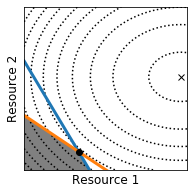

In [5]:
def d(R1,R2,params):
    return 0.5*((params['r'][0]/params['K'][0])*(R1-params['K'][0])**2
                +(params['r'][1]/params['K'][1])*(R2-params['K'][1])**2)

params = {'c':np.asarray([[0.5,0.3],[0.4,0.6]]),
          'r':np.asarray([1,1]),
          'K':np.asarray([4.8,2.85]),
          'm':np.asarray([1,1]),
          'w':np.asarray([1,1])}

def dydt(t,y):
    N = y[:2]
    R = y[2:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['m'])
    dRdt = (params['r']/params['K'])*R*(params['K']-R) - params['c'].T.dot(N)*R 
    return np.hstack((dNdt,dRdt))
tmin = 0.1
tmax = 100
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((np.ones(2),np.ones(2))),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:2,:].T
R = out_ODE.y[2:,:].T

fig,ax=plt.subplots(figsize=(3,3))
plot_d(d,params,ax=ax,f_values=np.linspace(0.1,5,15))
plot_ZNGI(params['c'],params['m'],ax=ax)
ax.plot([params['K'][0]],[params['K'][1]],'kx')
ax.plot([R[-1][0]],[R[-1][1]],'ko')
pdf = bpdf.PdfPages('MacArthur1_schem.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

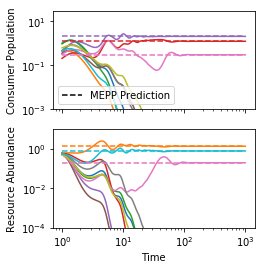

In [3]:
#Parameters
S = 10
M = 10
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'r':np.random.rand(M)+1,
          'K':np.random.rand(M)+5}
N_init = np.random.rand(S)
R_init = params['K']*0.1
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['m'])
    dRdt = (params['r']/params['K'])*R*(params['K']-R) - (params['c'].T.dot(N))*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return 0.5*((R-params['K'])**2*params['w']*params['r']/params['K']).sum()
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].loglog(t,R)
#Plot optimization results
if np.min(Nstar) < 0:
    print('Optimization Failed')
else:
    ax[0].set_prop_cycle(None)
    ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'--')
    ax[1].set_prop_cycle(None)
    ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'--')
    #Make legend
    ax[0].plot([],[],'k--',label='MEPP Prediction')
    ax[0].legend(loc=3)
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[0].set_ylim((1e-3,30))
ax[1].set_ylim((1e-4,10))
pdf = bpdf.PdfPages('MacArthur1_sim.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Interacting self-regulation

\begin{align}
\frac{dN_i}{dt} &= N_i\left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= R_\alpha\left(1 - \sum_\beta w_\beta R_\beta \right) -  \sum_i c_{i\alpha} N_i R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}) &=  \frac{1}{2}\left(1 - \sum_{\alpha} w_\alpha R_\alpha \right)^2\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha &\leq m_i\\
R_\alpha &\geq 0
\end{align}

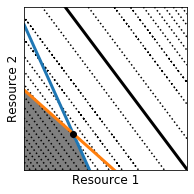

In [49]:
def d(R1,R2,params):
    return 0.5*(1-params['w'][0]*R1-params['w'][1]*R2)**2

params = {'c':np.asarray([[0.5,0.3],[0.4,0.6]]),
          'm':np.asarray([.2,.22]),
          'w':np.asarray([0.2,0.15])}

#ODE
S = 2
tmin = 0.1
tmax = 100000
N_init = N[-1]
R_init = R[-1]
def dydt(t,y):
    N = np.exp(y[:S])
    R = np.exp(y[S:])
    dlogNdt = ((params['c']*params['w']).dot(R)-params['m'])
    dlogRdt = (1-params['w'].dot(R)) - (params['c'].T.dot(N)).T
    return np.hstack((dlogNdt,dlogRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((np.log(N_init),np.log(R_init))),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = np.exp(out_ODE.y[:S,:].T)
R = np.exp(out_ODE.y[S:,:].T)

fig,ax=plt.subplots(figsize=(3,3))
plot_d(d,params,ax=ax,f_values=np.linspace(0.01,.5,15))
plot_ZNGI(params['c']*params['w'],params['m'],ax=ax)
R1 = np.linspace(0,5,100)
ax.plot(R1,(1-params['w'][0]*R1)/params['w'][1],'k',lw=3)
ax.plot([R[-1][0]],[R[-1][1]],'ko')
pdf = bpdf.PdfPages('MacArthur2_schem.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

In [6]:
2/20

0.1

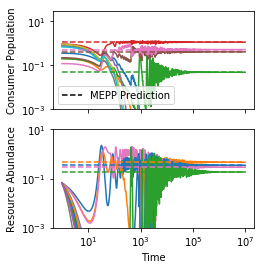

In [4]:
#Parameters
S = 10
M = 15
params = {'c':np.random.rand(S,M),
          'm':(np.random.rand(S)+1)/30,
          'w':(np.random.rand(M)+1)/20}
N_init = np.random.rand(S)
R_init = np.ones(M)/M
tmin = 1
tmax= 10000000

#ODE
def dydt(t,y):
    N = np.exp(y[:S])
    R = np.exp(y[S:])
    dlogNdt = ((params['c']*params['w']).dot(R)-params['m'])
    dlogRdt = (1-params['w'].dot(R)) - (params['c'].T.dot(N)).T
    return np.hstack((dlogNdt,dlogRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((np.log(N_init),np.log(R_init))),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = np.exp(out_ODE.y[:S,:].T)
R = np.exp(out_ODE.y[S:,:].T)

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return 0.5*(1 - params['w'].dot(R))**2
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].loglog(t,R)
#Plot optimization results
if np.min(Nstar) < 0:
    print('Optimization Failed')
else:
    ax[0].set_prop_cycle(None)
    ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'--')
    ax[1].set_prop_cycle(None)
    ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'--')
    #Make legend
    ax[0].plot([],[],'k--',label='MEPP Prediction')
    ax[0].legend(loc=3)
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[0].set_ylim((1e-3,30))
ax[1].set_ylim((1e-3,10))
pdf = bpdf.PdfPages('MacArthur2_sim.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Competition to withstand predators

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \sum_a p_{ia} P_a - m_i\right]\\
\frac{dR_\alpha}{dt} &= \frac{r_\alpha}{K_\alpha} R_\alpha (K_\alpha - R_\alpha) - \sum_i N_i c_{i\alpha} R_\alpha\\
\frac{dP_a}{dt} &= \sum_i p_{ia} N_i P_a - u_a P_a
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \frac{1}{2}\sum_\alpha \frac{r_\alpha}{K_\alpha} w_\alpha (R_\alpha - K_\alpha)^2 + \sum_a u_a P_a\\
\sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \sum_a p_{ia} P_a &\leq m_i\\
R_\alpha &\geq 0\\
P_\alpha &\geq 0
\end{align}

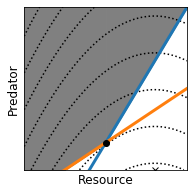

In [72]:
def d(R,P,params):
    return 0.5*(params['r']/params['K'])*(R-params['K'])**2+params['u']*P

params = {'c':np.asarray([0.5,0.4]),
          'p':np.asarray([0.3,0.6]),
          'm':np.asarray([1,.5]),
          'r':1,
          'K':4,
          'u':.5,
          'w':np.asarray([1])}

S = 2
MR = 1
N_init = np.ones(2)
P_init = np.ones(1)
R_init = np.ones(1)
tmin = 0.1
tmax = 1000
def dydt(t,y):
    N = y[:S]
    R = y[S:S+MR]
    P = y[S+MR:]
    dNdt = N*(params['c']*params['w']*R-params['p']*P-params['m'])
    dRdt = (params['r']/params['K'])*R*(params['K']-R) - (params['c'].T.dot(N))*R
    dPdt = (params['p'].T.dot(N))*P-params['u']*P
    return np.hstack((dNdt,dRdt,dPdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init,P_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:S+MR,:].T
P = out_ODE.y[S+MR:,:].T

fig,ax=plt.subplots(figsize=(3,3))
plot_d(d,params,ax=ax,f_values=np.linspace(0.1,8,15))
plot_ZNGI(np.vstack((params['c']*params['w'],-params['p'])).T,params['m'],ax=ax,flip=True)
ax.plot([params['K']],[0],'kx')
ax.plot([R[-1][0]],[P[-1][0]],'ko')
ax.set_xlabel('Resource')
ax.set_ylabel('Predator')
pdf = bpdf.PdfPages('MacArthur3_schem.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

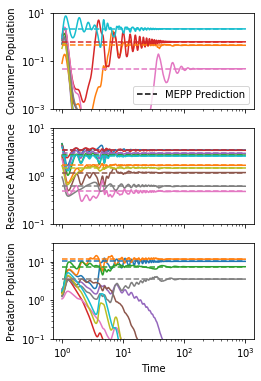

In [91]:
#Parameters
S = 10
MR = 10
MP = 10
params = {'c':np.random.rand(S,MR),
          'p':np.random.rand(S,MP),
          'm':np.random.rand(S)+1,
          'u':np.random.rand(MP)+1,
          'w':np.random.rand(MR)+1,
          'r':np.random.rand(MR)+1,
          'K':np.random.rand(MR)*5}
N_init = np.random.rand(S)
R_init = params['K']
P_init = np.random.rand(MP)+1
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:S+MR]
    P = y[S+MR:]
    dNdt = N*((params['c']*params['w']).dot(R)-params['p'].dot(P)-params['m'])
    dRdt = (params['r']/params['K'])*R*(params['K']-R) - (params['c'].T.dot(N))*R
    dPdt = (params['p'].T.dot(N))*P-params['u']*P
    return np.hstack((dNdt,dRdt,dPdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init,P_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:S+MR,:].T
P = out_ODE.y[S+MR:,:].T

#Constrained optimization
noninvadable = LinearConstraint(np.hstack((params['c']*params['w'],-params['p'])),-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(RP):
    R = RP[:MR]
    P = RP[MR:]                   
    return 0.5*((R-params['R0'])**2*params['w']*params['r']/params['K']).sum() + params['u'].dot(P)
out_opt = minimize(d, np.hstack((R_init,P_init)), method='trust-constr', constraints=noninvadable, bounds=resource_feasible)
Rstar = out_opt.x[:MR]
Pstar = out_opt.x[MR:]
Nstar = out_opt.v[0]

fig,ax=plt.subplots(3,sharex=True,figsize=(4,6))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].loglog(t,R)
ax[2].loglog(t,P)
#Plot optimization results
if np.min(Nstar) < 0:
    print('Optimization Failed')
else:
    ax[0].set_prop_cycle(None)
    ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'--')
    ax[1].set_prop_cycle(None)
    ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'--')
    ax[2].set_prop_cycle(None)
    ax[2].plot([t[0],t[-1]],[Pstar,Pstar],'--')
    #Make legend
    ax[0].plot([],[],'k--',label='MEPP Prediction')
    ax[0].legend(loc=3)
#Make labels
ax[2].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[2].set_ylabel('Predator Population')
ax[0].set_ylim((1e-3,10))
ax[1].set_ylim((1e-1,10))
ax[2].set_ylim((1e-1,30))
pdf = bpdf.PdfPages('MacArthur3_sim.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Chemostat

\begin{align}
\frac{dN_i}{dt} &= N_i \left[ \sum_{\alpha} w_\alpha c_{i\alpha} R_\alpha - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \kappa_\alpha -\tau^{-1} R_\alpha - \sum_i N_i c_{i\alpha} R_\alpha.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha\left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
R^0_\alpha &= \tau \kappa_\alpha
\end{align}


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


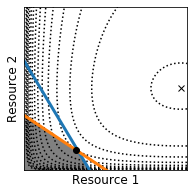

In [13]:
def d(R1,R2,params):
    R0 = params['tau']*params['kappa']
    return (params['w'][0]*R0[0]*np.log(R0[0]/R1) + params['w'][1]*R0[1]*np.log(R0[1]/R2)
            -params['w'][0]*(R0[0]-R1)-params['w'][1]*(R0[1]-R2))/params['tau']

params = {'c':np.asarray([[0.5,0.3],[0.4,0.6]]),
          'tau':1,
          'kappa':np.asarray([4.8,2.5]),
          'm':np.asarray([1,1]),
          'w':np.asarray([1,1])}

tmin=1
tmax=1000
S=2
N_init=np.ones(2)
R_init=np.ones(2)
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-1/params['tau'])
    dRdt = params['kappa']-R/params['tau'] - (params['c'].T.dot(N))*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

fig,ax=plt.subplots(figsize=(3,3))
plot_d(d,params,ax=ax,f_values=np.linspace(0.1,17,15))
plot_ZNGI(params['c'],params['m'],ax=ax)
ax.plot([params['kappa'][0]*params['tau']],[params['kappa'][1]*params['tau']],'kx')
ax.plot([R[-1][0]],[R[-1][1]],'ko')
pdf = bpdf.PdfPages('MacArthur4_schem.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

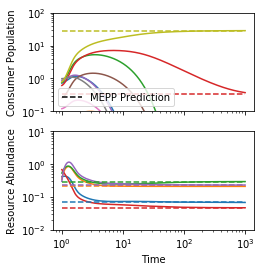

In [19]:
#Parameters
S = 9
M = 5
params = {'c':np.random.rand(S,M),
          'w':np.random.rand(M)+1,
          'tau':1,
          'kappa':np.random.rand(M)*6+1}
N_init = np.random.rand(S)
R_init = np.random.rand(M)
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']).dot(R)-1/params['tau'])
    dRdt = params['kappa'] - R/params['tau'] - (params['c'].T.dot(N))*R
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w'],-np.inf*np.ones(S),np.ones(S)/params['tau'])
resource_feasible = Bounds(0,np.inf)
def d(R):
    return params['w'].dot(kl_div(params['kappa']*params['tau'],R))/params['tau']
def jac(R):
    return params['w']*(R-params['kappa']*params['tau'])/(R*params['tau'])
def hess(R):
    return np.diag(params['w']*params['kappa']*params['tau']/(R**2*params['tau']))
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x
Nstar = out_opt.v[0]

fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].loglog(t,R)
#Plot optimization results
ax[0].set_prop_cycle(None)
ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'--')
ax[1].set_prop_cycle(None)
ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'--')
#Make legend
ax[0].plot([],[],'k--',label='MEPP Prediction')
ax[0].legend(loc=3)
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[0].set_ylim((1e-1,100))
ax[1].set_ylim((1e-2,10))
pdf = bpdf.PdfPages('MacArthur4_sim.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Saturating

\begin{align}
\frac{dN_i}{dt} &= e_i N_i \left[\frac{J_i \sum_\alpha w_\alpha c_{i\alpha}R_\alpha}{J_i + \sum_\alpha w_\alpha c_{i\alpha}R_\alpha} - m_i\right] - \tau^{-1}N_i\\
\frac{dR_\alpha}{dt} &= \tau^{-1} (R_\alpha^0 - R_\alpha) - \sum_i N_i\frac{J_i c_{i\alpha}R_\alpha}{J_i+\sum_\beta w_\beta c_{i\beta}R_\beta}.
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha\left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] 
\end{align}

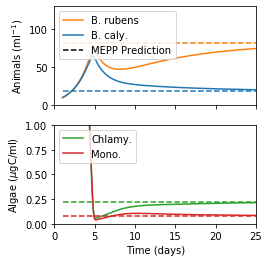

In [61]:
S = 2
M = 2
#Parameters taken from data analysis in Rothhaupt Analysis.ipynb
params = {'c':np.asarray([[0.427,0.211],[0.049,0.252]]),#np.random.rand(S,M),
          'e':np.asarray([13.8,72.8]),#np.random.rand(S)+3,
          'm':np.asarray([.0363,.00947]),#(np.random.rand(S)+1)/3,
          'w':np.ones(M),#np.random.rand(M)+1,
          'J':np.asarray([0.0927,0.0202]),#np.random.rand(S)+1,
          'tau':1/0.2,
          'R0':np.asarray([6,4])}#np.random.rand(M)+5}
N_init = np.asarray([10,10])
R_init = params['R0']
tmin = 1
tmax= 100

#ODE
def g(R):
    return params['e']*(params['J']*(params['c']*params['w']).dot(R)/(params['J']+(params['c']*params['w']).dot(R)) - params['m'])
def g_jac(R):
    return ((params['c']*params['w']).T*params['J']**2*params['e']/(params['J']+(params['c']*params['w']).dot(R))**2).T
def g_hess(R,v):
    return np.einsum('i,ij,ik',-v*2*params['J']**2*params['e']/(params['J']+(params['c']*params['w']).dot(R))**3,params['c']*params['w'],params['c']*params['w'])
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = (params['R0']-R)/params['tau'] - (params['c']*R).T.dot(params['J']*N/(params['J']+(params['c']*params['w']).dot(R)))
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = NonlinearConstraint(g,-np.inf,1/params['tau'],jac=g_jac,hess=g_hess)
resource_feasible = Bounds(0,np.inf)
def d(R):
    return params['w'].dot(kl_div(params['R0'],R))/params['tau']
def jac(R):
    return params['w']*(R-params['R0'])/(R*params['tau'])
def hess(R):
    return np.diag(params['w']*params['R0']/R**2)/params['tau']
out_opt = minimize(d, R_init, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=jac, hess=hess)
Rstar = out_opt.x
Nstar = out_opt.v[0]*params['J']*params['e']/(params['J']+(params['c']*params['w']).dot(Rstar))

fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].plot(t,N[:,1],label = 'B. rubens',color=colors[1])
ax[0].plot(t,N[:,0],label = 'B. caly.',color=colors[0])
ax[1].plot(t,R[:,0],label='Chlamy.',color=colors[2])
ax[1].plot(t,R[:,1],label='Mono.',color=colors[3])
#Plot optimization results
if np.min(Nstar) < 0:
    print('Optimization Failed')
else:
    ax[0].set_prop_cycle(None)
    ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'--')
    ax[1].set_prop_cycle(None)
    ax[1].plot([t[0],t[-1]],[Rstar[0],Rstar[0]],'--',color=colors[2])
    ax[1].plot([t[0],t[-1]],[Rstar[1],Rstar[1]],'--',color=colors[3])
    #Make legend
    ax[0].plot([],[],'k--',label='MEPP Prediction')
    ax[0].legend(loc=2)
    ax[1].legend(loc=2)
#Make labels
ax[1].set_xlabel('Time (days)')
ax[0].set_ylabel(r'Animals (ml$^{-1}$)')
ax[1].set_ylabel('Algae ($\mu$gC/ml)')
ax[0].set_ylim((0,130))
ax[1].set_ylim((0,1))
ax[1].set_xlim((0,25))
pdf = bpdf.PdfPages('Rothhaupt_sim.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

In [60]:
Nstar

array([4.45925773e-03, 2.67305014e+02])

# Asymmetric models

## Liebig's Law

\begin{align}
\frac{dN_i}{dt} &= N_i \left[{\rm min}\left(\left\{c_{i\alpha} R_\alpha\right\}\right) - \tau^{-1}\right]\\
\frac{dR_\alpha}{dt} &= \kappa_\alpha - \tau^{-1} R_\alpha - \sum_{i} N_i \nu_{\alpha i} {\rm min}\left(\left\{c_{i\alpha} R_\alpha\right\}\right).
\end{align}

\begin{align}
d(\mathbf{R}^0,\mathbf{R}) &= \tau^{-1} \sum_\alpha w_\alpha \left[R_\alpha^0 \ln \frac{R_\alpha^0}{R_\alpha} - (R_\alpha^0 - R_\alpha)\right] \\
R_\alpha^0 &= \tau \left(\kappa_\alpha - \sum_{\beta \neq \alpha} \bar{N}_\beta \nu_{\alpha \beta} {\rm min}\left(\left\{c_{\beta\alpha} \bar{R}_\alpha\right\}\right)\right)\\
w_\alpha &= 1/\nu_{\alpha\alpha}
\end{align}

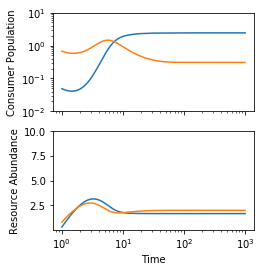

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


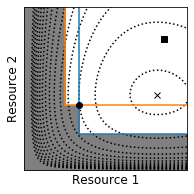

In [7]:
def d(R1,R2,params):
    R0 = params['R0t']
    return (R0[0]*np.log(R0[0]/R1) + R0[1]*np.log(R0[1]/R2)
            -(R0[0]-R1)-(R0[1]-R2))/params['tau']

params = {'c':np.asarray([[0.6,0.9],[0.8,0.5]]),
          'nu':np.asarray([[1,.7],[0.7,1]]),
          'tau':1,
          'kappa':np.asarray([4.3,4])}
#ODE
S=2
def g(R):
    return np.min(params['c']*R,axis=1)
def nu(R):
    return np.asarray([params['nu'][:,np.argmin(params['c'][k,:]*R)] for k in range(S)])
tmin = 1
tmax= 1000
N_init = np.random.rand(2)
R_init = np.random.rand(2)
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = params['kappa']- R/params['tau'] - nu(R).T.dot(g(R)*N)
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T
fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].semilogx(t,R)
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[0].set_ylim((1e-2,10))
ax[1].set_ylim((1e-2,10))
pdf = bpdf.PdfPages('Liebig_sim_small.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

nu_nolim = nu(R[-1])-np.diag(np.diag(nu(R[-1])))
params['R0t'] = params['tau']*(params['kappa']-nu_nolim.T.dot(g(R[-1])*N[-1]))

fig,ax=plt.subplots(figsize=(3,3))
plot_d(d,params,ax=ax,f_values=np.linspace(0.1,8,15))
plot_ZNGI(params['c'],np.ones(2)/params['tau'],ax=ax,kind='essential')
ax.plot([params['kappa'][0]*params['tau']],[params['kappa'][1]*params['tau']],'ks')
ax.plot([params['R0t'][0]],[params['R0t'][1]],'kx')
ax.plot([R[-1][0]],[R[-1][1]],'ko')
pdf = bpdf.PdfPages('Liebig_schem.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

34.74577507956336
29.53422467220236
40.145821835040316
41.08903894161882
45.24071718544031
45.60986156544421
47.23404208640541
47.37790862486692
48.0131880815494
48.069156168357665
48.31766839138531
48.339562053353504
48.43677472116983
48.44533899733335
48.4833662126921
48.486716337695434
48.5015916037447
48.50290208408992
48.50872089684351
48.50923352171703
48.51150968699573
48.51171021207943
48.51260058740654


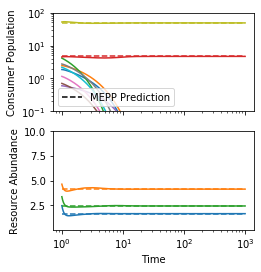

In [159]:
#Parameters
S = 10
M = 3
params = {'c':np.random.rand(S,M),
          'nu':np.random.rand(M,S),
          'tau':1,
          'kappa':np.random.rand(M)+20}
#Improve odds that system will be stable
params['nu'] = np.ones((M,S))/params['c'].T + np.random.rand(M,S)*0.1
#Normalize
params['nu'] = params['nu']/params['nu'].sum(axis=0)

#Set up constraints
def g(R):
    return np.min(params['c']*R,axis=1)
def g_jac(R):
    jac = np.zeros((S,M))
    for k in range(S):
        jmin = np.argmin(params['c'][k,:]*R)
        jac[k,jmin] = params['c'][k,jmin]
    return jac
def g_hess(R,v):
    return np.zeros((M,M))
noninvadable = NonlinearConstraint(g,-np.inf,1/params['tau'],jac=g_jac,hess=g_hess)
resource_feasible = Bounds(0,np.inf)

#Set up objective function
def effective_params(Rstar,Nstar):
    beta_i = np.asarray([np.argmin(params['c'][k,:]*Rstar) for k in range(S)])
    nu_nolim = params['nu'].copy()
    nu_nolim[beta_i,range(S)] = 0
    R0t = params['tau']*(params['kappa']-nu_nolim.dot(g(Rstar)*Nstar))
    w = np.ones(M)
    w[beta_i[Nstar>0]] = 1/params['nu'][beta_i[Nstar>0],np.where(Nstar>0)[0]]
    return R0t, w
def d(R,Rstar,Nstar):
    R0t, w = effective_params(Rstar,Nstar)
    return w.dot(kl_div(R0t,R))
def jac(R,Rstar,Nstar):
    R0t, w = effective_params(Rstar,Nstar)
    return w*(R-R0t)/R
def hess(R,Rstar,Nstar):
    R0t, w = effective_params(Rstar,Nstar)
    return w*np.diag(R0t/R**2)

#Initialize optimization
Rstar = params['kappa']*params['tau']
Nstar = np.ones(S)*1e-9
Rstar_old = np.zeros(M)
Nstar_old = np.ones(S)*100
eps = 1e-3
max_iter = 100
thresh=.5
k = 0

#Iteratively optimize, automatically updating effective supply point at each step
while (np.linalg.norm(Rstar-Rstar_old) > eps or np.linalg.norm(Nstar-Nstar_old) > eps) and k < max_iter:
    out_opt = minimize(lambda R: d(R,Rstar,Nstar), Rstar, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=lambda R: jac(R,Rstar,Nstar), hess=lambda R: hess(R,Rstar,Nstar),options={'maxiter':1e9})
    if out_opt.success:
        Rstar_old = Rstar
        Nstar_old = Nstar
        Rstar = out_opt.x
        Nstar = out_opt.v[0]
        Nstar[Nstar<thresh] = 0
        print(np.max(Nstar))
    else:
        print('Optimization failed')
        Rstar = Rstar*(1+np.random.randn(M)*0.3)
        Nstar = Nstar*(1+np.random.randn(S)*0.3)
    k+=1

#Solve ODE's, starting near the MEPP solution
N_init = Nstar*(1+0.3*np.random.randn(S))
N_init[N_init==0] = 5*np.random.rand(np.sum(N_init==0))
R_init = Rstar*(1+0.3*np.random.randn(M))
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*(g(R)-1/params['tau'])
    dRdt = params['kappa']-R/params['tau'] - params['nu'].dot(g(R)*N)
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Make plots
fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].semilogx(t,R)
#Plot optimization results
if np.min(Nstar) < 0:
    print('Optimization Failed')
else:
    ax[0].set_prop_cycle(None)
    ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'--')
    ax[1].set_prop_cycle(None)
    ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'--')
    #Make legend
    ax[0].plot([],[],'k--',label='MEPP Prediction')
    ax[0].legend(loc=3)
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[0].set_ylim((1e-1,100))
ax[1].set_ylim((1e-2,10))
pdf = bpdf.PdfPages('Liebig_sim.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

## Microbial Consumer Resource Model

\begin{align}
\frac{dN_i}{dt} &= N_i \left[\sum_\alpha (1-l_\alpha) w_\alpha c_{i\alpha} R_\alpha - m_i\right]\\
\frac{dR_\alpha}{dt} &= \kappa - \tau^{-1} R_\alpha - \sum_{i,\beta} N_i\frac{\delta_{\alpha\beta} - D_{\alpha\beta}l_\beta}{w_\alpha(1-l_\beta)}(1-l_\beta)w_\beta c_{i\beta}R_\beta 
\end{align}

\begin{align}
R_\alpha^0 = \tau\left(\kappa + \sum_i \bar{N}_i D_{\alpha\beta}l_\beta\frac{w_\beta}{w_\alpha} c_{i\beta}\bar{R}_\beta\right)
\end{align}

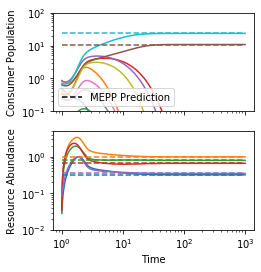

In [32]:
#Parameters
S = 10
M = 5
params = {'c':np.random.rand(S,M),
          'm':np.random.rand(S)+1,
          'w':np.random.rand(M)+1,
          'l':np.random.rand(M),
          'tau':1,
          'D':np.random.dirichlet(np.ones(M)*10,size=M).T,
          'kappa':np.random.rand(M)*10}
N_init = np.random.rand(S)
R_init = np.random.rand(M)*0.1
tmin = 1
tmax= 1000

#ODE
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((params['c']*params['w']*(1-params['l'])).dot(R)-params['m'])
    dRdt = params['kappa']-R/params['tau'] - (params['c'].T.dot(N))*R + (params['D']*params['l']).dot((params['c']*params['w']).T.dot(N)*R)/params['w']
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T

#Constrained optimization
noninvadable = LinearConstraint(params['c']*params['w']*(1-params['l']),-np.inf*np.ones(S),params['m'])
resource_feasible = Bounds(0,np.inf)
def d(R,Rstar,Nstar):
    R0t = params['tau']*(params['kappa']+(params['D']*params['l']).dot((params['c']*params['w']).T.dot(Nstar)*Rstar)/params['w'])
    return ((1-params['l'])*params['w']).dot(kl_div(R0t,R))
def jac(R,Rstar,Nstar):
    R0t = params['tau']*(params['kappa']+(params['D']*params['l']).dot((params['c']*params['w']).T.dot(Nstar)*Rstar)/params['w'])
    return ((1-params['l'])*params['w'])*(R-R0t)/R
def hess(R,Rstar,Nstar):
    R0t = params['tau']*(params['kappa']+(params['D']*params['l']).dot((params['c']*params['w']).T.dot(Nstar)*Rstar)/params['w'])
    return np.diag(((1-params['l'])*params['w'])*R0t/R**2)
Rstar = np.ones(M)
Rstar_old = np.zeros(M)
eps = 1e-3
max_iter = 100
k = 0
Nstar = np.zeros(len(params['c']))
while np.linalg.norm(Rstar-Rstar_old) > eps and k < max_iter:
    out_opt = minimize(lambda R: d(R,Rstar,Nstar), Rstar, method='trust-constr', constraints=noninvadable, bounds=resource_feasible, jac=lambda R: jac(R,Rstar,Nstar), hess=lambda R: hess(R,Rstar,Nstar))
    Rstar_old = Rstar
    Rstar = out_opt.x
    Nstar = out_opt.v[0]
    k+=1


fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].loglog(t,R)
#Plot optimization results
if np.min(Nstar) < 0:
    print('Optimization Failed')
else:
    ax[0].set_prop_cycle(None)
    ax[0].plot([t[0],t[-1]],[Nstar,Nstar],'--')
    ax[1].set_prop_cycle(None)
    ax[1].plot([t[0],t[-1]],[Rstar,Rstar],'--')
    #Make legend
    ax[0].plot([],[],'k--',label='MEPP Prediction')
    ax[0].legend(loc=3)
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[0].set_ylim((1e-1,100))
ax[1].set_ylim((1e-2,5))
pdf = bpdf.PdfPages('MiCRM_sim.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()

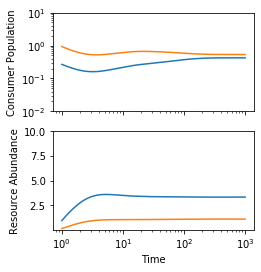

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.


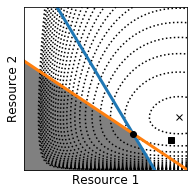

In [35]:
def d(R1,R2,params):
    R0 = params['R0t']
    return (params['w'][0]*R0[0]*np.log(R0[0]/R1) + params['w'][1]*R0[1]*np.log(R0[1]/R2)
            -params['w'][0]*(R0[0]-R1)-params['w'][1]*(R0[1]-R2))/params['tau']

c = np.asarray([[0.5,0.3],[0.4,0.6]])
D = np.asarray([[0,1],[1,0]])
R0 = [4.5,0.9]
l=0.5
m=2
params={'c':c,
        'D':D,
        'm':m*(1-l)*np.ones(2),
        'l':l*np.ones(2),
        'w':np.ones(2),
        'g':1,
        'kappa':np.asarray(R0),
        'tau':1.
       }
#ODE
tmin = 1
tmax= 1000
N_init = np.random.rand(2)
R_init = np.random.rand(2)
S=2
def dydt(t,y):
    N = y[:S]
    R = y[S:]
    dNdt = N*((1-params['l'])*(params['c']*params['w']).dot(R)-params['m'])
    dRdt = params['kappa']- R/params['tau'] - params['c'].T.dot(N)*R + params['l']*params['D'].dot((params['c']*params['w']*R).T.dot(N))/params['w']
    return np.hstack((dNdt,dRdt))
out_ODE = solve_ivp(dydt,(tmin,tmax),np.hstack((N_init,R_init)),t_eval=np.logspace(np.log10(tmin),np.log10(tmax),1000))
t = out_ODE.t
N = out_ODE.y[:S,:].T
R = out_ODE.y[S:,:].T
fig,ax=plt.subplots(2,sharex=True,figsize=(4,4))
fig.subplots_adjust(left=0.2)
#Plot ODE results
ax[0].loglog(t,N)
ax[1].semilogx(t,R)
#Make labels
ax[1].set_xlabel('Time')
ax[0].set_ylabel('Consumer Population')
ax[1].set_ylabel('Resource Abundance')
ax[0].set_ylim((1e-2,10))
ax[1].set_ylim((1e-2,10))
pdf = bpdf.PdfPages('MiCRM_sim_small.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()


params['R0t'] = params['tau']*(params['kappa']+(params['D']*params['l']).dot((params['c']*params['w']).T.dot(N[-1])*R[-1])/params['w'])
fig,ax=plt.subplots(figsize=(3,3))
plot_d(d,params,ax=ax,f_values=np.linspace(0.1,7,25))
plot_ZNGI((1-params['l'])*params['c']*params['w'],params['m'],ax=ax)
ax.plot([params['kappa'][0]*params['tau']],[params['kappa'][1]*params['tau']],'ks')
ax.plot([params['R0t'][0]],[params['R0t'][1]],'kx')
ax.plot([R[-1][0]],[R[-1][1]],'ko')
pdf = bpdf.PdfPages('MiCRM_schem.pdf')
pdf.savefig(fig)
pdf.close()
plt.show()